### Deeper comparison of implemented methods

This notebook has the goal of seeing patterns and trends that occur in the implemented methods.

In [10]:
import os
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import git

### Epoch length based on number of GPUs

Let's measure how long does each epoch take, based on the number of GPUs used.

In [11]:
repo = git.Repo('.', search_parent_directories=True)

results_path = os.path.join(repo.working_tree_dir, 'results')
r1_acc = pd.read_csv(os.path.join(results_path, 'r1_acc.csv'))
r1_time = pd.read_csv(os.path.join(results_path, 'r1_time.csv'))

In [12]:
r2_acc = pd.read_csv(os.path.join(results_path, 'r2_acc.csv'))
r2_time = pd.read_csv(os.path.join(results_path, 'r2_time.csv'))

p2_acc = pd.read_csv(os.path.join(results_path, 'p2_acc.csv'))
p2_time = pd.read_csv(os.path.join(results_path, 'p2_time.csv'))

In [13]:
r4_acc = pd.read_csv(os.path.join(results_path, 'r4_acc.csv'))
r4_time = pd.read_csv(os.path.join(results_path, 'r4_time.csv'))

p4_acc = pd.read_csv(os.path.join(results_path, 'p4_acc.csv'))
p4_time = pd.read_csv(os.path.join(results_path, 'p4_time.csv'))

Text(0.5, 1.0, 'Average epoch time for different strategies and number of GPUs')

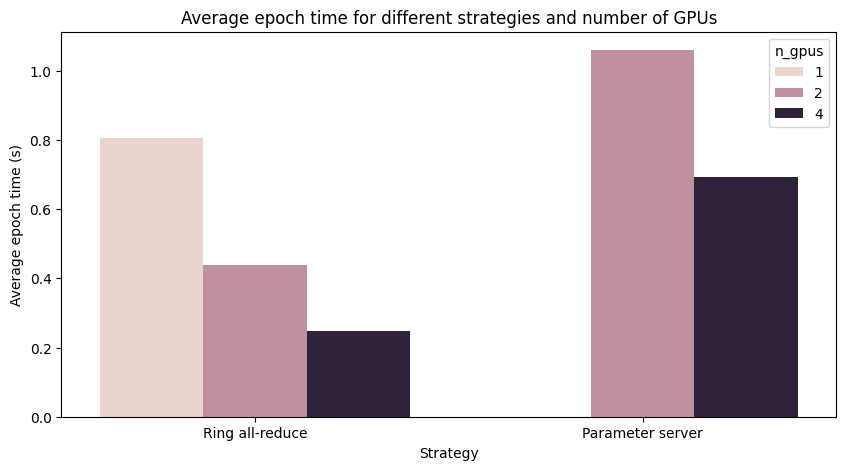

In [14]:
fig = plt.figure(figsize=(10, 5))

r1_avg_epoch_time = r1_time['time'].diff().mean()
r2_avg_epoch_time = r2_time['time'].diff().mean()
r4_avg_epoch_time = r4_time['time'].diff().mean()

p4_avg_epoch_time = p4_time['time'].diff().mean()
p2_avg_epoch_time = p2_time['time'].diff().mean()

avg_epoch_df = pd.DataFrame({
    'Strategy': ['Ring all-reduce', 'Ring all-reduce', 'Ring all-reduce', 'Parameter server', 'Parameter server'],
    'n_gpus': [1, 2, 4, 2, 4],
    'avg_epoch_time': [r1_avg_epoch_time, r2_avg_epoch_time, r4_avg_epoch_time, p2_avg_epoch_time, p4_avg_epoch_time]
})

sns.barplot(x='Strategy', y='avg_epoch_time', hue='n_gpus', data=avg_epoch_df)
plt.ylabel('Average epoch time (s)')
plt.title('Average epoch time for different strategies and number of GPUs')

We can see several interesting things from this barplot. 
Firstly, Ring all-reduce beats the parameter server around 2.5x for the same number of GPUs, showing the superiority of ring all-reduce in terms of epoch time efficiency.

Secondly, as we increase the number of GPUs, epoch time decreases for both methods. For Ring all-reduce, doubling the number of GPUs almost halves the epoch time: since epoch calculation takes majority of the time, it is split in half, because half the dataset is used for each GPU. For parameter server, the decrease is about 1.6 times, since this strategy has bigger communication overhead.

### Time to 100% acc

Let's measure how much each algorithm

In [15]:
def time_to_100_acc(time, acc):
    idx = acc[acc['acc'] == 1.0].index[0]
    return time['time'][idx], idx


Text(0.5, 1.0, 'Time to 100% accuracy for different strategies and number of GPUs')

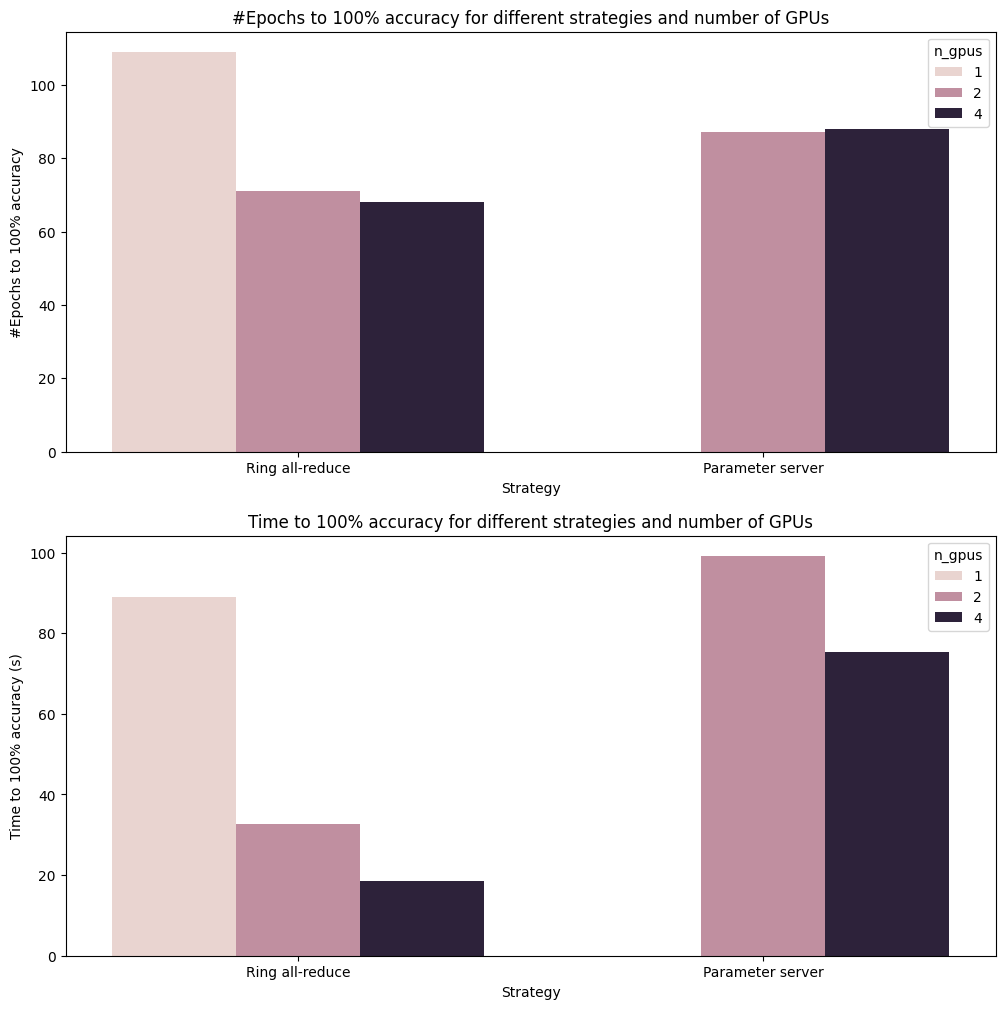

In [16]:
r1_time_to_100, r1_idx = time_to_100_acc(r1_time, r1_acc)
r2_time_to_100, r2_idx = time_to_100_acc(r2_time, r2_acc)
r4_time_to_100, r4_idx = time_to_100_acc(r4_time, r4_acc)

p2_time_to_100, p2_idx = time_to_100_acc(p2_time, p2_acc)
p4_time_to_100, p4_idx = time_to_100_acc(p4_time, p4_acc)

time_to_100_df = pd.DataFrame({
    'Strategy': ['Ring all-reduce', 'Ring all-reduce', 'Ring all-reduce', 'Parameter server', 'Parameter server'],
    'n_gpus': [1, 2, 4, 2, 4],
    'time_to_100': [r1_time_to_100, r2_time_to_100, r4_time_to_100, p2_time_to_100, p4_time_to_100],
    'epochs_to_100':[r1_idx, r2_idx, r4_idx, p2_idx, p4_idx]
})

fix, ax = plt.subplots(2,1, figsize=(12, 12))
plt.subplot(2, 1, 1)
sns.barplot(x='Strategy', y='epochs_to_100', hue='n_gpus', data=time_to_100_df)

plt.ylabel('#Epochs to 100% accuracy')

plt.title('#Epochs to 100% accuracy for different strategies and number of GPUs')

plt.subplot(2,1, 2)
sns.barplot(x='Strategy', y='time_to_100', hue='n_gpus', data=time_to_100_df)

plt.ylabel('Time to 100% accuracy (s)')
plt.title('Time to 100% accuracy for different strategies and number of GPUs')

We can see several things from these plots:

1. Apart from single-GPU training, number of epochs needed to reach 100% accuracy doesn't change much with the change in number of GPUs.

2. Time to achieve 100% accuracy decreases significanty with the increase in number of GPUs. This is explained by the fact that epochs are completed faster, as we saw earlier.

3. Again, ring all-reduce outperforms the parameter server by a large margin

### Scaling based on dataset size

Let's see how the algorithms scale with the increase in dataset size.

In [17]:
param_server_times = [pd.read_csv(os.path.join(results_path, f'time_p{i}k.csv')) for i in [1, 10, 50]]
ring_all_reduce_times = [pd.read_csv(os.path.join(results_path, f'time_r{i}k.csv')) for i in [1, 10, 50]]

Text(0.5, 1.0, 'Average epoch time for different training sizes')

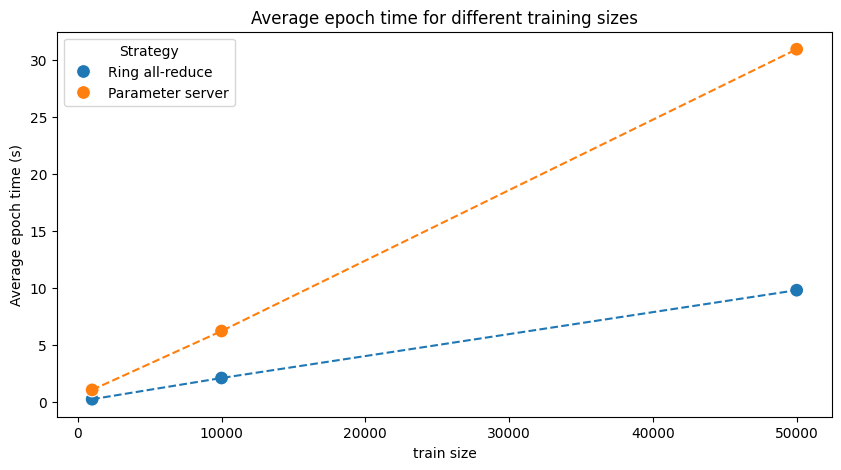

In [25]:
p_avg_epoch_times_means = [df['time'].diff().mean() for df in param_server_times]
p_avg_epoch_times_std = [df['time'].diff().std() for df in param_server_times]

r_avg_epoch_times_means = [df['time'].diff().mean() for df in ring_all_reduce_times]
r_avg_epoch_times_std = [df['time'].diff().std() for df in ring_all_reduce_times]

avg_epoch_df = pd.DataFrame({
    'Strategy': ['Ring all-reduce', 'Ring all-reduce', 'Ring all-reduce', 'Parameter server', 'Parameter server', 'Parameter server'],
    'train size': [1000, 10000, 50000, 1000, 10000, 50000],
    'avg_epoch_time_means': r_avg_epoch_times_means + p_avg_epoch_times_means,
})

plt.figure(figsize=(10, 5))

sns.scatterplot(x='train size', y='avg_epoch_time_means', hue='Strategy', data=avg_epoch_df, s=100)

for i in range(2):
    plt.plot(avg_epoch_df['train size'].unique(), avg_epoch_df['avg_epoch_time_means'][i*3:i*3+3], label=avg_epoch_df['Strategy'][i*3], linestyle='dashed')


r_coeff = r_avg_epoch_times_means[0] / r_avg_epoch_times_means[1]
p_coeff = p_avg_epoch_times_means[0] / p_avg_epoch_times_means[1]


plt.ylabel('Average epoch time (s)')
plt.title('Average epoch time for different training sizes')



From this plot, we can see that ring all-reduce shows a better scaling curve than the parameter server method. We see predictable scaling laws for both methods.